### Importing Necessary Libraries

In [240]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import tensorflow as tf
!pip install imutils
import imutils
import cv2
import matplotlib.pyplot as plt

### Loading the VGG16 model trained on ImageNet dataset

In [241]:
model = VGG16(weights="imagenet")

### Path to the input image file

In [242]:
file_path= "/kaggle/input/fountain/tom-wheatley-Ym1bPWvPA4U-unsplash.jpg"

### Loading the image and preprocessing it for the model

In [255]:
orig = cv2.imread(file_path)
resized = cv2.resize(orig, (224, 224))
image = load_img(file_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

### Predictions using the pre-trained model

In [244]:
preds = model.predict(image)
i = np.argmax(preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


### Decoding the prediction results

In [245]:
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob)= decoded[0][0]
label = "{}: {:.2f}%".format(label, prob*100)
print("[INFO]{}".format(label))

[INFO]fountain: 100.00%


### Class for GradCAM visualization

***We define a class for GradCAM visualization, compute the heatmap, overlay it on the original image, and generate the visualization.***

In [246]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self): # To find the last 4D convolutional layer
        for layer in reversed(self.model.layers):
            if len(layer.output.shape) == 4:
                return layer.name
        
        raise ValueError("Could not find 4D Layer. Cannot apply GradCAM")
    
    def compute_heatmap(self, image, eps=1e-8):  # Computing the heatmap
        gradModel = Model(inputs=self.model.inputs, outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        grads = tape.gradient(loss, convOutputs)
        
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET): # Method to overlay the heatmap on the original image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        return (heatmap, output)

In [247]:
cam=GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

In [248]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [249]:
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [132,  44,  26],
        [138,  44,  26],
        [138,  42,  23]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [133,  46,  28],
        [139,  46,  28],
        [139,  45,  26]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [134,  46,  28],
        [141,  50,  30],
        [144,  51,  30]],

       ...,

       [[154, 129,  60],
        [156, 132,  62],
        [158, 133,  64],
        ...,
        [152, 128,  64],
        [150, 127,  62],
        [150, 126,  62]],

       [[151, 126,  57],
        [153, 128,  59],
        [156, 131,  62],
        ...,
        [151, 127,  62],
        [150, 126,  61],
        [149, 126,  60]],

       [[152, 127,  58],
        [153, 128,  59],
        [155, 130,  61],
        ...,
        [150, 126,  60],
        [148, 125,  58],
        [148, 125,  58]]

## Displaying the concatenated output image

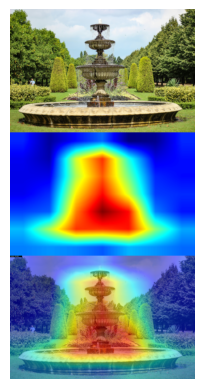

In [250]:
orig_resized = imutils.resize(orig, width=output.shape[1])
heatmap_resized = imutils.resize(heatmap, width=output.shape[1])

output_concatenated = np.vstack([orig_resized, heatmap_resized, output])
output_concatenated = imutils.resize(output_concatenated, height=700)

cv2.imwrite("output.jpg", output_concatenated)

output_concatenated_rgb = cv2.cvtColor(output_concatenated, cv2.COLOR_BGR2RGB)
plt.imshow(output_concatenated_rgb)
plt.axis('off')
plt.show()

## Displaying individual components: original image, heatmap, overlay, and concatenated output

***Finally, we display the GradCAM visualization along with the original image, heatmap, overlay, and concatenated output for better understanding.***

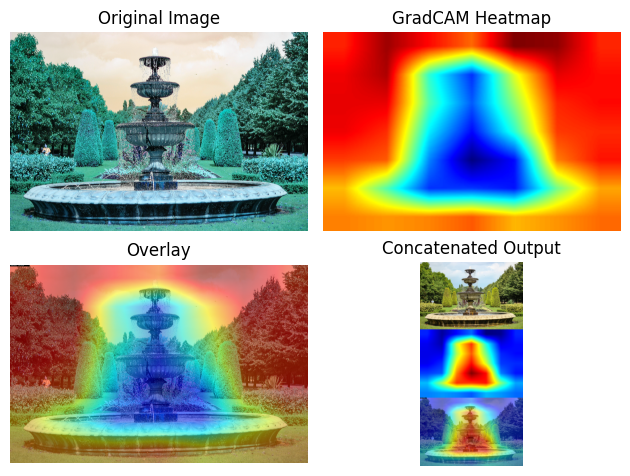

In [251]:
#Original
plt.subplot(2,2,1) 
plt.imshow(orig)
plt.title('Original Image')
plt.axis('off')

# Heatmap
plt.subplot(2,2,2)
plt.imshow(heatmap)
plt.title('GradCAM Heatmap')
plt.axis('off')

# Overlay
plt.subplot(2,2,3)
plt.imshow(output) 
plt.title('Overlay')
plt.axis('off')

# Concatenated output
plt.subplot(2,2,4)
plt.imshow(output_concatenated_rgb)
plt.title('Concatenated Output')
plt.axis('off') 

plt.tight_layout()
plt.show()